In [7]:
## This is the final document for implementing our tag model.

In [8]:
## Libraries required.

# Basics

import pandas as pd
import numpy as np
import re

#Visual
import seaborn as sns
import matplotlib.pyplot as plt

#Sklearn
from sklearn import tree as sk_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score, max_error, explained_variance_score
from sklearn.model_selection import train_test_split



In [10]:
## Opening the dataset.

df = pd.read_csv("C:/Users/Magalhaes/Desktop/Database FGVFlow - Página1.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Magalhaes/Desktop/Database FGVFlow - Página1.csv'

## Data exploration

In [ ]:
df.head()
df.info()

## Dataframe working 100%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Q User          110 non-null    int64 
 1   Q ID            110 non-null    int64 
 2   Title           110 non-null    object
 3   Questions Body  110 non-null    object
 4   Q Score         110 non-null    int64 
 5   Answer user     110 non-null    int64 
 6   Answers Body    110 non-null    object
 7   A Score         110 non-null    int64 
 8   Tags            110 non-null    object
dtypes: int64(5), object(4)
memory usage: 7.9+ KB


In [ ]:
df.describe()

,Q User,Q ID,Q Score,Answer user,A Score
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,348711.427273,55.500000,24.436364,353472.027273,12.336364
std,30519.566053,31.898276,61.100238,28119.239577,32.752695
min,300751.000000,1.000000,1.000000,301291.000000,0.000000
25%,324510.000000,28.250000,4.000000,332464.250000,1.000000
50%,347410.500000,55.500000,6.000000,350845.500000,2.000000
75%,372838.500000,82.750000,22.000000,379885.500000,10.000000
max,398940.000000,110.000000,545.000000,399017.000000,300.000000


In [ ]:
# Lets first clean the base so we can select the variables we need for the model.

df.drop({"Q User", "Q ID", "Answer user"}, axis=1, inplace=True)
df

,Title,Questions Body,Q Score,Answers Body,A Score,Tags
0,What is anarchy?,I did not really got what anarchy is. Does som...,5,"Anarchy is, firstly, a structure in which a sy...",2,International History; Anarchy
1,What is the difference between international a...,"Answering the list 3 of IR Theory, I couldn't ...",4,"Yes, you are",1,IR Theory
2,SRA number,What is the SRA phone number?,3,It's (11) 929292-92929,17,SRA
3,Get ready for microeconomics exam,I am having a microeconomics exam next week an...,6,"First of all, review your mock exams and your ...",6,Microeconomics
4,Getting in touch with Oliver Stuenkel,"Hi, folks! I must talk w/ Oliver asap, but I c...",1,You can access the list of OH links in the int...,5,Contact
...,...,...,...,...,...,...
105,Nice movies and IR,"Advise me on some nice IR related movies, plea...",19,There is a nice show called Bortført.,100,Movie; IR
106,UiO Exchange,"Hello, guys! I am going to the University of O...",23,Sure! You should look if they are offering a c...,10,Exchange program
107,All syllabus,Does anyone know where I can find the syllabi ...,24,You can find it in intranet. All syllabi — for...,12,Syllabus
108,Predictive Analytics,Is taking the predictive analytics elective co...,24,"It is very hard, but totally worth. I learned ...",12,Predictive Analytics


In [ ]:
## Lets check if there are duplicate values

df.duplicated().sum()

## There are no duplicated values.

0

In [ ]:
## What about NAs?

total = df.isnull().sum().sort_values(ascending=False)

percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(20)

## There are no missing data in the dataframe.

,Total,Percent
Title,0,0.0
Questions Body,0,0.0
Q Score,0,0.0
Answers Body,0,0.0
A Score,0,0.0
Tags,0,0.0


In [ ]:
## Lets check if there is any correlation between both question and answer score.

corr_matrix = df.corr().sort_values(
    by = "Q Score",  ascending=False, key = abs)
corr_matrix

## There is a correlation but is not that significant.

,Q Score,A Score
Q Score,1.000000,0.427872
A Score,0.427872,1.000000


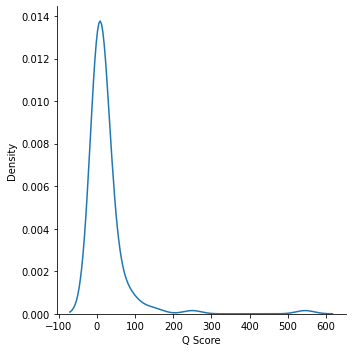

In [ ]:
## Lets see how the distribution of scores goes

sns.displot(df, x="Q Score", kind="kde")

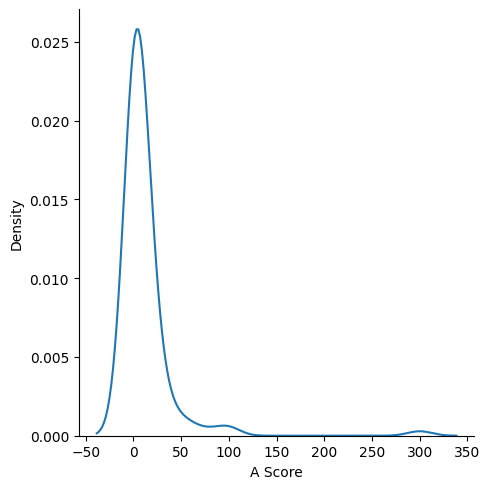

In [ ]:
# Now for answer scores

sns.displot(df, x="A Score", kind="kde")

In [ ]:
## Now lets see how tags work in this dataframe.

tags = df.groupby(['Tags'], sort=True)['Tags'].count()
tags.sort_values(ascending=False).head(20)

## As expected, tags related to International Relations are those most common in the dataframe.

Tags
IR Theory                          10
Exchange program                    9
General                             8
International Development           7
SRA                                 6
Brazilian Foreign Policy            5
International Political Economy     5
Data science                        4
Grades                              4
Game Theory                         3
Calendar                            3
International Law; fairness         3
Thesis                              2
Macroeconomy                        2
Internship                          2
International Law                   2
Writing                             2
Career                              2
Contact                             2
Classes policy                      2
Name: Tags, dtype: int64

## Preparation of the model

Cleaning the Questions Body

In [23]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acdej\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [24]:
import re
from bs4 import BeautifulSoup

! pip install nltk
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

You should consider upgrading via the 'C:\Users\acdej\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [25]:
## Opening the dataset.

df = pd.read_csv("C:/Users/acdej/Documents/1 Faculdade/8° Semestre/Ambiente Negócios/Database FGVFlow - Página1.csv")

In [26]:
df.drop({"Q User", "Q ID", "Answer user"}, axis=1, inplace=True)
df

,Title,Questions Body,Q Score,Answers Body,A Score,Tags
0,What is anarchy?,I did not really got what anarchy is. Does som...,5,"Anarchy is, firstly, a structure in which a sy...",2,International History; Anarchy
1,What is the difference between international a...,"Answering the list 3 of IR Theory, I couldn't ...",4,"Yes, you are",1,IR Theory
2,SRA number,What is the SRA phone number?,3,It's (11) 929292-92929,17,SRA
3,Get ready for microeconomics exam,I am having a microeconomics exam next week an...,6,"First of all, review your mock exams and your ...",6,Microeconomics
4,Getting in touch with Oliver Stuenkel,"Hi, folks! I must talk w/ Oliver asap, but I c...",1,You can access the list of OH links in the int...,5,Contact
...,...,...,...,...,...,...
105,Nice movies and IR,"Advise me on some nice IR related movies, plea...",19,There is a nice show called Bortført.,100,Movie; IR
106,UiO Exchange,"Hello, guys! I am going to the University of O...",23,Sure! You should look if they are offering a c...,10,Exchange program
107,All syllabus,Does anyone know where I can find the syllabi ...,24,You can find it in intranet. All syllabi — for...,12,Syllabus
108,Predictive Analytics,Is taking the predictive analytics elective co...,24,"It is very hard, but totally worth. I learned ...",12,Predictive Analytics


In [28]:
X = df['Text']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

KeyError: 'Text'

In [15]:
df['Questions Body'] = df['Questions Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

C:\Users\acdej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [16]:
df.head(5)

,Title,Questions Body,Q Score,Answers Body,A Score,Tags
0,What is anarchy?,I did not really got what anarchy is. Does som...,5,"Anarchy is, firstly, a structure in which a sy...",2,International History; Anarchy
1,What is the difference between international a...,"Answering the list 3 of IR Theory, I couldn't ...",4,"Yes, you are",1,IR Theory
2,SRA number,What is the SRA phone number?,3,It's (11) 929292-92929,17,SRA
3,Get ready for microeconomics exam,I am having a microeconomics exam next week an...,6,"First of all, review your mock exams and your ...",6,Microeconomics
4,Getting in touch with Oliver Stuenkel,"Hi, folks! I must talk w/ Oliver asap, but I c...",1,You can access the list of OH links in the int...,5,Contact


In [17]:
df['Questions Body']=df['Questions Body'].str.replace('<p>',' ')

In [18]:
df['Questions Body']=df['Questions Body'].apply(lambda x : re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)' , ' ' , x))

In [19]:
df['Questions Body']=df['Questions Body'].str.replace('</p>',' ')
df['Questions Body']=df['Questions Body'].str.replace('\n',' ')
df['Questions Body']=df['Questions Body'].str.replace('</a>',' ')